In [52]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to Python path for module imports (since we're in notebooks/ subdirectory)
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added parent directory to Python path: {parent_dir}")

# Also add current directory
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)
    print(f"Added current directory to Python path: {current_dir}")

# KFP imports
from kfp import dsl
from kfp.compiler import Compiler

print(f"Python version: {sys.version}")
print(f"Current working directory: {os.getcwd()}")
print(f"Python path includes: {sys.path[:3]}...")

# Create directories for local execution
Path("local_outputs").mkdir(exist_ok=True)
Path("local_outputs/models").mkdir(exist_ok=True)
Path("local_outputs/data").mkdir(exist_ok=True)
Path("local_outputs/metrics").mkdir(exist_ok=True)


Python version: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 17.0.0 (clang-1700.0.13.3)]
Current working directory: /Users/sonika.arora/workspace/kubeflow-pipelines/notebooks
Python path includes: ['/Users/sonika.arora/workspace/kubeflow-pipelines/notebooks', '/Users/sonika.arora/workspace/kubeflow-pipelines', '/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python311.zip']...


In [53]:
def load_data_local(dataset_url="https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"):
    """Local version of load_data component"""
    print(f"Loading data from: {dataset_url}")
    
    # Load the dataset
    df = pd.read_csv(dataset_url)
    
    # Basic data cleaning
    df = df.dropna()
    
    # Save the processed dataset
    output_path = "local_outputs/data/iris_dataset.csv"
    df.to_csv(output_path, index=False)
    
    print(f"Dataset saved to: {output_path}")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())
    
    return {
        'dataset_path': output_path,
        'num_rows': len(df),
        'num_columns': len(df.columns),
        'dataframe': df
    }

# Test the data loading
data_result = load_data_local()
df = data_result['dataframe']


Loading data from: https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv
Dataset saved to: local_outputs/data/iris_dataset.csv
Dataset shape: (150, 5)
Columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

First few rows:
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [54]:
def train_model_local(dataset_path, target_column="species", test_size=0.2, random_state=42):
    """Local version of train_model component"""
    print(f"Training model with data from: {dataset_path}")
    
    # Load the dataset
    df = pd.read_csv(dataset_path)
    
    # Prepare features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    print(f"Features: {list(X.columns)}")
    print(f"Target: {target_column}")
    print(f"Target classes: {y.unique()}")
    
    # Handle categorical variables in features
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    
    # Handle categorical target if necessary
    le_target = None
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
    else:
        y_encoded = y
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Train the model
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Training accuracy: {accuracy:.4f}")
    
    # Save the model
    model_path = "local_outputs/models/iris_model.pkl"
    joblib.dump(model, model_path)
    
    # Save label encoder if used
    if le_target:
        encoder_path = "local_outputs/models/label_encoder.pkl"
        joblib.dump(le_target, encoder_path)
    
    # Save metrics
    metrics = {
        'accuracy': accuracy,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features': list(X.columns),
        'target_classes': list(y.unique()) if le_target is None else list(le_target.classes_)
    }
    
    metrics_path = "local_outputs/metrics/training_metrics.json"
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print(f"Model saved to: {model_path}")
    print(f"Metrics saved to: {metrics_path}")
    
    return {
        'model_path': model_path,
        'accuracy': accuracy,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'model': model,
        'label_encoder': le_target
    }

# Test the model training
train_result = train_model_local(data_result['dataset_path'])


Training model with data from: local_outputs/data/iris_dataset.csv
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Target: species
Target classes: ['setosa' 'versicolor' 'virginica']
Target encoding: {'setosa': np.int64(0), 'versicolor': np.int64(1), 'virginica': np.int64(2)}
Training samples: 120
Test samples: 30
Training accuracy: 1.0000
Model saved to: local_outputs/models/iris_model.pkl
Metrics saved to: local_outputs/metrics/training_metrics.json


In [47]:
def evaluate_model_local(model_path, dataset_path, target_column="species"):
    """Local version of evaluate_model component"""
    print(f"Evaluating model from: {model_path}")
    
    # Load the model
    model = joblib.load(model_path)
    
    # Try to load label encoder
    encoder_path = "local_outputs/models/label_encoder.pkl"
    le_target = None
    if os.path.exists(encoder_path):
        le_target = joblib.load(encoder_path)
    
    # Load test data
    df = pd.read_csv(dataset_path)
    
    # Prepare features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Handle categorical variables (same preprocessing as training)
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    
    # Handle categorical target if necessary
    if le_target:
        y_encoded = le_target.transform(y)
        class_names = le_target.classes_
    else:
        y_encoded = y
        class_names = y.unique()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y_encoded, y_pred)
    
    print(f"Final model accuracy: {accuracy:.4f}")
    
    # Generate classification report
    if le_target:
        target_names = le_target.classes_
    else:
        target_names = None
    
    report = classification_report(y_encoded, y_pred, target_names=target_names)
    print("\nClassification Report:")
    print(report)
    
    # Get model size
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")
    
    # Save evaluation metrics
    eval_metrics = {
        'final_accuracy': accuracy,
        'model_size_mb': model_size_mb,
        'test_samples': len(X),
        'classification_report': report
    }
    
    eval_path = "local_outputs/metrics/evaluation_metrics.json"
    with open(eval_path, 'w') as f:
        json.dump(eval_metrics, f, indent=2)
    
    print(f"Evaluation metrics saved to: {eval_path}")
    
    return {
        'final_accuracy': accuracy,
        'model_size_mb': model_size_mb,
        'y_true': y_encoded,
        'y_pred': y_pred,
        'class_names': class_names,
        'classification_report': report
    }

# Test the model evaluation
eval_result = evaluate_model_local(train_result['model_path'], data_result['dataset_path'])


Evaluating model from: local_outputs/models/iris_model.pkl
Final model accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       1.00      0.94      0.97        50
   virginica       0.94      1.00      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Model size: 0.00 MB
Evaluation metrics saved to: local_outputs/metrics/evaluation_metrics.json


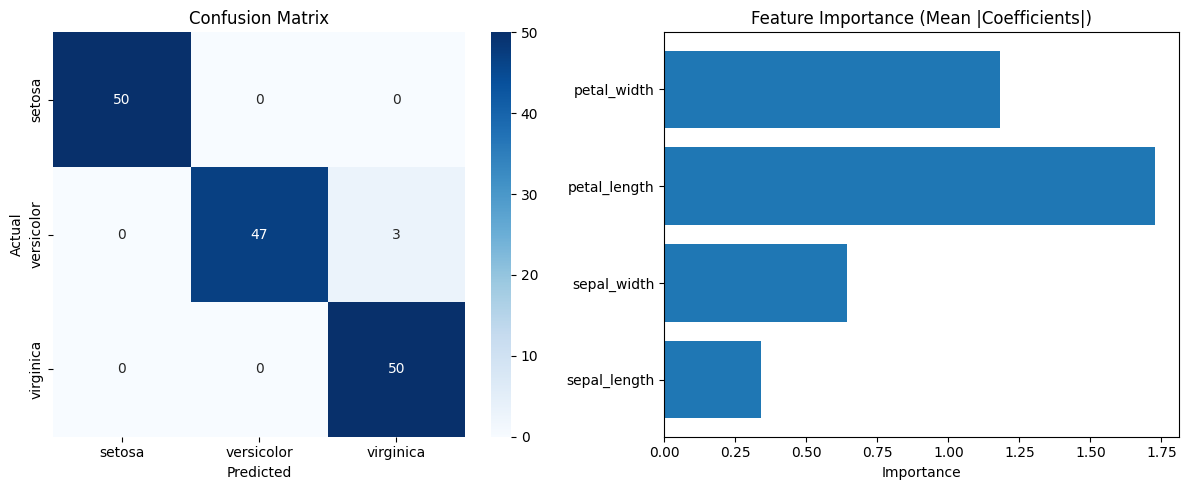


Pipeline Summary:
Dataset: 150 rows, 5 columns
Training samples: 120
Test samples: 30
Final accuracy: 0.9800
Model size: 0.00 MB


In [48]:
# Plot confusion matrix and feature importance
plt.figure(figsize=(12, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(eval_result['y_true'], eval_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=eval_result['class_names'], 
            yticklabels=eval_result['class_names'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature importance (coefficients for logistic regression)
plt.subplot(1, 2, 2)
model = train_result['model']
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# For multiclass, we'll use the mean absolute coefficients
if len(model.coef_) > 1:
    importance = np.mean(np.abs(model.coef_), axis=0)
else:
    importance = np.abs(model.coef_[0])

plt.barh(feature_names, importance)
plt.title('Feature Importance (Mean |Coefficients|)')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

print(f"\nPipeline Summary:")
print(f"Dataset: {data_result['num_rows']} rows, {data_result['num_columns']} columns")
print(f"Training samples: {train_result['train_samples']}")
print(f"Test samples: {train_result['test_samples']}")
print(f"Final accuracy: {eval_result['final_accuracy']:.4f}")
print(f"Model size: {eval_result['model_size_mb']:.2f} MB")


In [49]:
## 🔄 Import Pipeline Components

print("🔍 Attempting to import pipeline components...")

# Method 1: Try importing from pipelines module
try:
    from pipelines.ml_training_pipeline import ml_training_pipeline
    print("✅ Successfully imported pipeline from pipelines module")
    pipeline_func = ml_training_pipeline
    pipeline_name = "ml-training-pipeline"
    
except ImportError as e1:
    print(f"❌ Import error: {e1}")
    print("🔄 Trying alternative import...")
    
    # Method 2: Try importing components directly
    try:
        from components.ml_ops_components import load_data, train_model, evaluate_model
        print("✅ Successfully imported components from components module")
        
        # Define pipeline inline
        @dsl.pipeline(
            name="ml-training-pipeline-local",
            description="A machine learning pipeline that trains and stores a model on the Iris dataset"
        )
        def ml_training_pipeline_local(
            dataset_url: str = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
        ):
            # Load data
            load_data_task = load_data(dataset_url=dataset_url)
            
            # Train model
            train_model_task = train_model(dataset_path=load_data_task.outputs['dataset_path'])
            
            # Evaluate model
            evaluate_model_task = evaluate_model(
                dataset_path=load_data_task.outputs['dataset_path'],
                model_path=train_model_task.outputs['model_path']
            )
            
            # Set dependencies
            train_model_task.after(load_data_task)
            evaluate_model_task.after(train_model_task)
        
        pipeline_func = ml_training_pipeline_local
        pipeline_name = "ml-training-pipeline-local"
        print("✅ Pipeline defined successfully using inline definition")
        
    except ImportError as e2:
        print(f"❌ Could not import components: {e2}")
        print("🔄 Trying pipelines.components...")
        
        # Method 3: Try importing from pipelines.components
        try:
            from pipelines.components.ml_ops_components import load_data, train_model, evaluate_model
            print("✅ Successfully imported from pipelines.components module")
            
            # Define pipeline inline
            @dsl.pipeline(
                name="ml-training-pipeline-nested",
                description="A machine learning pipeline using nested components"
            )
            def ml_training_pipeline_nested(
                dataset_url: str = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
            ):
                # Load data
                load_data_task = load_data(dataset_url=dataset_url)
                
                # Train model
                train_model_task = train_model(dataset_path=load_data_task.outputs['dataset_path'])
                
                # Evaluate model
                evaluate_model_task = evaluate_model(
                    dataset_path=load_data_task.outputs['dataset_path'],
                    model_path=train_model_task.outputs['model_path']
                )
                
                # Set dependencies
                train_model_task.after(load_data_task)
                evaluate_model_task.after(train_model_task)
            
            pipeline_func = ml_training_pipeline_nested
            pipeline_name = "ml-training-pipeline-nested"
            print("✅ Pipeline defined successfully using nested components")
            
        except ImportError as e3:
            print(f"❌ All import methods failed. Last error: {e3}")
            print("⚠️ Please check your directory structure and Python path")
            print(f"Current working directory: {os.getcwd()}")
            print("Available directories:")
            for item in os.listdir('..'):  # Look in parent directory
                if os.path.isdir(os.path.join('..', item)):
                    print(f"  📁 {item}/")
            
            # Show what's in pipelines directory
            if os.path.exists('../pipelines'):
                print("\nContents of ../pipelines/ directory:")
                for item in os.listdir('../pipelines'):
                    print(f"  📄 {item}")
                    
            raise ImportError("Could not import pipeline components using any method")

print(f"📋 Selected pipeline: {pipeline_name}")
print("🚀 Ready for compilation!")


🔍 Attempting to import pipeline components...
✅ Successfully imported pipeline from pipelines module
📋 Selected pipeline: ml-training-pipeline
🚀 Ready for compilation!


In [50]:
## Compile the Pipeline

# Compile the selected pipeline
compiler = Compiler()
pipeline_package_path = f'local_outputs/{pipeline_name.replace("-", "_")}.yaml'

print(f"🔧 Compiling pipeline: {pipeline_name}")
print(f"📁 Output path: {pipeline_package_path}")

try:
    compiler.compile(
        pipeline_func=pipeline_func,
        package_path=pipeline_package_path
    )
    print(f"✅ Pipeline compiled successfully!")
    
    # Get file size
    file_size = os.path.getsize(pipeline_package_path) / 1024  # KB
    print(f"📊 Pipeline YAML size: {file_size:.1f} KB")
    
    # Display the pipeline YAML (first 50 lines)
    with open(pipeline_package_path, 'r') as f:
        lines = f.readlines()
        print(f"\n📄 Pipeline YAML preview (first 50 of {len(lines)} lines):")
        print("=" * 60)
        print(''.join(lines[:50]))
        if len(lines) > 50:
            print(f"... ({len(lines) - 50} more lines)")
        print("=" * 60)
            
except Exception as e:
    print(f"❌ Error compiling pipeline: {e}")
    import traceback
    traceback.print_exc()


🔧 Compiling pipeline: ml-training-pipeline
📁 Output path: local_outputs/ml_training_pipeline.yaml
✅ Pipeline compiled successfully!
📊 Pipeline YAML size: 24.5 KB

📄 Pipeline YAML preview (first 50 of 428 lines):
# PIPELINE DEFINITION
# Name: ml-training-pipeline
# Description: A machine learning pipeline that trains and stores a model on the Iris dataset
# Inputs:
#    dataset_url: str [Default: 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv']
# Outputs:
#    evaluate-model-model_metrics: system.Metrics
components:
  comp-evaluate-model:
    executorLabel: exec-evaluate-model
    inputDefinitions:
      artifacts:
        model_input:
          artifactType:
            schemaTitle: system.Model
            schemaVersion: 0.0.1
        test_dataset:
          artifactType:
            schemaTitle: system.Dataset
            schemaVersion: 0.0.1
    outputDefinitions:
      artifacts:
        model_metrics:
          artifactType:
            schemaTitle: system

In [51]:
# List all generated files
import os

def list_files_recursive(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)
            print(f"{subindent}{file} ({file_size} bytes)")

print("Generated files:")
if os.path.exists("local_outputs"):
    list_files_recursive("local_outputs")

# Display metrics files if they exist
if os.path.exists("local_outputs/metrics/training_metrics.json"):
    print("\n" + "="*50)
    print("TRAINING METRICS:")
    with open("local_outputs/metrics/training_metrics.json", 'r') as f:
        training_metrics = json.load(f)
        print(json.dumps(training_metrics, indent=2))

if os.path.exists("local_outputs/metrics/evaluation_metrics.json"):
    print("\n" + "="*50)
    print("EVALUATION METRICS:")
    with open("local_outputs/metrics/evaluation_metrics.json", 'r') as f:
        eval_metrics = json.load(f)
        # Don't print the full classification report as it's long
        eval_metrics_summary = {k: v for k, v in eval_metrics.items() if k != 'classification_report'}
        print(json.dumps(eval_metrics_summary, indent=2))


Generated files:
local_outputs/
  ml_training_pipeline.yaml (25055 bytes)
  metrics/
    evaluation_metrics.json (513 bytes)
    training_metrics.json (240 bytes)
  models/
    label_encoder.pkl (507 bytes)
    iris_model.pkl (1295 bytes)
  data/
    iris_dataset.csv (3858 bytes)

TRAINING METRICS:
{
  "accuracy": 1.0,
  "train_samples": 120,
  "test_samples": 30,
  "features": [
    "sepal_length",
    "sepal_width",
    "petal_length",
    "petal_width"
  ],
  "target_classes": [
    "setosa",
    "versicolor",
    "virginica"
  ]
}

EVALUATION METRICS:
{
  "final_accuracy": 0.98,
  "model_size_mb": 0.0012350082397460938,
  "test_samples": 150
}
